# 13. 추론
- 고전적 통계 추론에서, 추론에서 사용하는 가장 일반적인 도구는 스튜던트 t-검정과 p-value (**영가설 유의성 검정**)
- 베이지안 방식에서는 두 집단 간의 차이에 대한 사후분포를 계산

    이 분포를 기준으로, 가장 가능성 있는 차이가 어떻게 되고, 실제 차이 정도의 신용구간은 어떻게 되는지, 한 집단이 가장 클 확률은 얼마인지, 차이 정도가 특정 기준을 넘어갈 확률은 얼마인지 에 대한 분석

In [2]:
from os.path import basename, exists

def download(url):
    filename = basename(url)
    if not exists(filename):
        from urllib.request import urlretrieve
        local, _ = urlretrieve(url, filename)
        print('Downloaded ' + local)
    
download('https://github.com/AllenDowney/ThinkBayes2/raw/master/soln/utils.py')

from utils import set_pyplot_params
set_pyplot_params()

<br>

## 13.01. 독해 능력 향상

[DASL](https://web.archive.org/web/20000603124754/http://lib.stat.cmu.edu/DASL/Datafiles/DRPScores.html), 데이터 스토리를 수집하는 웹페이지의 
1987년 작성된 [교육 심리학 논문](https://docs.lib.purdue.edu/dissertations/AAI8807671/)의 내용

> 한 교육자는 교실에서 새로운 지시적 읽기 활동이 초등학생의 읽기 능력의 일부 측면을 향상시키는 데 도움이 되는지 여부를 알아보기 위해 실험을 수행했다. 이 교육자는 21명의 3학년생을 대상으로 8주간 실험을 진행했다. 다른 3학년 23명의 통제군 교실에서는 이 활동이 없는 기존과 동일한 커리큘럼을 따랐다. 8주 후 모든 학생들은 이 새로운 활동이 읽기 능력에 얼마나 도움이 되는지를 측정하는 읽기 능력 등급 (DRP) 시험을 치뤘다.

The [dataset is available here](https://web.archive.org/web/20000603124754/http://lib.stat.cmu.edu/DASL/Datafiles/DRPScores.html).

<br>

- `Treatment`열에는 각 학생이 실험군인지 통제군인지 표시
* `Response`열의 값은 시험 점수

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [6]:
download('https://github.com/AllenDowney/ThinkBayes2/raw/master/data/drp_scores.csv')

In [7]:
df = pd.read_csv('drp_scores.csv', skiprows=21, delimiter='\t')
df.head(3)

,Treatment,Response
0,Treated,24
1,Treated,43
2,Treated,58


#### 실험군(Treated)와 비교군 (Control)로 분할

In [8]:
grouped = df.groupby('Treatment')
responses = {}

for name, group in grouped:
    responses[name] = group['Response']

<br>

### 두 집단 점수의 CDF와 요약통계량
- 두 분포 간에는 겹치는 부분이 있으나, 전반적으로 실험군의 점수가 더 높아보임
- **점수 분포는 각 그룹 모두 정확한 정규분포를 나타내지는 않으나, 정규분포 모델을 선택해도 충분히 납득할 수 있을 정도의 형태**

    **$\rightarrow$ 학생의 모집단에서 (실험군과 대조군 이외의 학생 포함), 점수의 분포는 정규분포를  띄고, 아직 평균과 표준편차는 알 수 없다고 가정**
    
    **$\rightarrow$ 이 두 값을 `mu`와 `sigma`로 나타내고, 이 값을 추정하기 위하여 베이지안 갱신을 사용**

In [11]:
from empiricaldist import Cdf
from utils import decorate

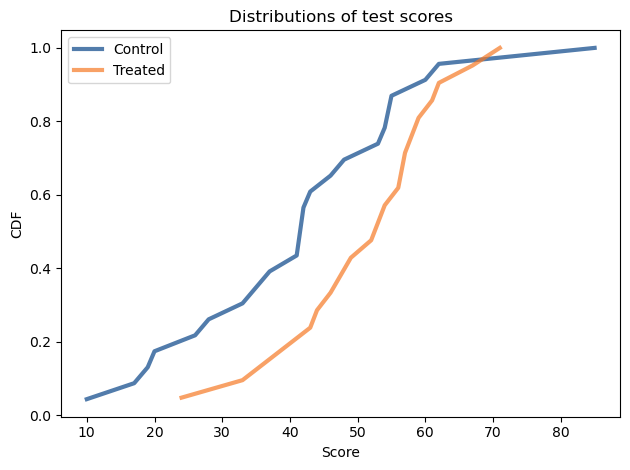

In [13]:
for name, response in responses.items():
    cdf = Cdf.from_seq(response)
    cdf.plot(label=name)
    
decorate(xlabel='Score', ylabel='CDF', title='Distributions of test scores')

<br>

## 13.02. 매개변수 추정

#### 매개변수에 대한 사전분포가 필요 $\rightarrow$ 두 개의 매개변수 (`mu`, `sigma`)에 대한 결합분포 사용
**각 매개변수에 대한 주변분포를 선택한 후, 둘의 외적을 계산**

<br>

- `mu`와 `sigma`를 균등분포로 가정

In [15]:
from empiricaldist import Pmf

In [16]:
def make_uniform(qs, name=None, **options):
    
    """균등분포 Pmf 생성"""
    pmf = Pmf(1.0, qs, **options)
    pmf.normalize()
    if name:
        pmf.index.name = name
        
    return pmf

<br>

#### `mu`에 대한 균등사전분포

In [20]:
qs = np.linspace(20, 80, num=101)
prior_mu = make_uniform(qs, name='mean')

prior_mu.head()

,probs
mean,
20.0,0.009901
20.6,0.009901
21.2,0.009901


<br>

#### `sigma`에 대한 균등사전분포

In [22]:
qs = np.linspace(5, 30, num=101)
prior_sigma = make_uniform(qs, name='std')
prior_sigma.head()

,probs
std,
5.00,0.009901
5.25,0.009901
5.50,0.009901


<br>

#### 결합분포 생성

In [23]:
from utils import make_joint

In [30]:
prior = make_joint(prior_mu, prior_sigma)

prior

mean,20.0,20.6,21.2,21.8,22.4,23.0,23.6,24.2,24.8,25.4,...,74.6,75.2,75.8,76.4,77.0,77.6,78.2,78.8,79.4,80.0
std,,,,,,,,,,,,,,,,,,,,,
5.00,0.000098,0.000098,0.000098,0.000098,0.000098,0.000098,0.000098,0.000098,0.000098,0.000098,...,0.000098,0.000098,0.000098,0.000098,0.000098,0.000098,0.000098,0.000098,0.000098,0.000098
5.25,0.000098,0.000098,0.000098,0.000098,0.000098,0.000098,0.000098,0.000098,0.000098,0.000098,...,0.000098,0.000098,0.000098,0.000098,0.000098,0.000098,0.000098,0.000098,0.000098,0.000098
5.50,0.000098,0.000098,0.000098,0.000098,0.000098,0.000098,0.000098,0.000098,0.000098,0.000098,...,0.000098,0.000098,0.000098,0.000098,0.000098,0.000098,0.000098,0.000098,0.000098,0.000098
5.75,0.000098,0.000098,0.000098,0.000098,0.000098,0.000098,0.000098,0.000098,0.000098,0.000098,...,0.000098,0.000098,0.000098,0.000098,0.000098,0.000098,0.000098,0.000098,0.000098,0.000098
6.00,0.000098,0.000098,0.000098,0.000098,0.000098,0.000098,0.000098,0.000098,0.000098,0.000098,...,0.000098,0.000098,0.000098,0.000098,0.000098,0.000098,0.000098,0.000098,0.000098,0.000098
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29.00,0.000098,0.000098,0.000098,0.000098,0.000098,0.000098,0.000098,0.000098,0.000098,0.000098,...,0.000098,0.000098,0.000098,0.000098,0.000098,0.000098,0.000098,0.000098,0.000098,0.000098
29.25,0.000098,0.000098,0.000098,0.000098,0.000098,0.000098,0.000098,0.000098,0.000098,0.000098,...,0.000098,0.000098,0.000098,0.000098,0.000098,0.000098,0.000098,0.000098,0.000098,0.000098
29.50,0.000098,0.000098,0.000098,0.000098,0.000098,0.000098,0.000098,0.000098,0.000098,0.000098,...,0.000098,0.000098,0.000098,0.000098,0.000098,0.000098,0.000098,0.000098,0.000098,0.000098


<br>

## 13.03. 가능도

#### `mu`와 `sigma`의 각 가설값 쌍에 대한 데이터셋의 각 점수별 확률
- 첫 번째 축에는 `mu`의 값

    두 번째 축에는 `sigma`의 값
    
    세 번째 축에는 비교군 데이터셋 점수

In [38]:
data = responses['Control']
data.shape

(23,)

In [34]:
mu_mesh, sigma_mesh, data_mesh = np.meshgrid(prior.columns, prior.index, data)

mu_mesh.shape, sigma_mesh.shape, data_mesh.shape

((101, 101, 23), (101, 101, 23), (101, 101, 23))

#### 각 가설값 쌍에 대한 각 점수의 확률 밀도

In [31]:
from scipy.stats import norm

In [32]:
densities = norm(mu_mesh, sigma_mesh).pdf(data_mesh)
densities.shape

(101, 101, 23)

#### 결괏값은 3차원 배열 $\rightarrow$ 데이터 축인 `axis=2`에 따라 밀도값을 곱해서 가능도를 계산

In [41]:
likelihood = densities.prod(axis=2)
likelihood.shape

(101, 101)


<br>

### 갱신

#### 가능도는 각 매개변수의 가설값 쌍에 2차원 배열 $\rightarrow$ 이 배열을 사전분포 갱신에 사용


In [44]:
from utils import normalize

In [45]:
posterior = prior * likelihood
normalize(posterior)
posterior.shape

(101, 101)

<br>

*위 과정을 하나의 함수로*

In [46]:
def update_norm(prior, data):
    """Update the prior based on data."""
    mu_mesh, sigma_mesh, data_mesh = np.meshgrid(prior.columns, prior.index, data)
    
    densities = norm(mu_mesh, sigma_mesh).pdf(data_mesh)
    likelihood = densities.prod(axis=2)
    
    posterior = prior * likelihood
    normalize(posterior)

    return posterior

- 통제군에 대한 갱신

In [49]:
data = responses['Control']
posterior_control = update_norm(prior, data)

- 실험군에 대한 갱신

In [50]:
data = responses['Treated']
posterior_treated = update_norm(prior, data)

<br>

#### `mu`와 `sigma`의 사후결합분포 시각화

In [51]:
import matplotlib.pyplot as plt
from utils import plot_contour

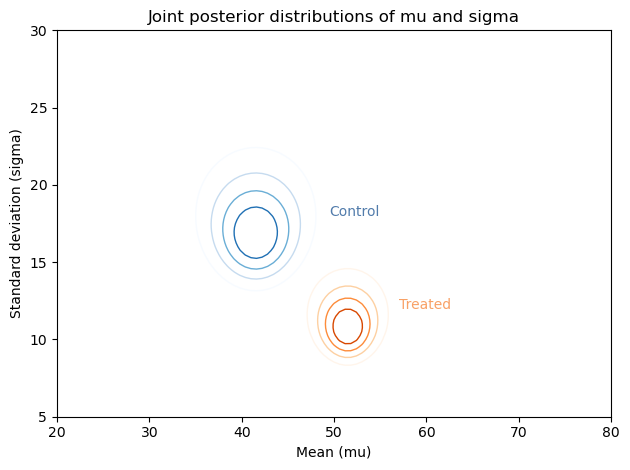

In [52]:
plot_contour(posterior_control, cmap='Blues')
plt.text(49.5, 18, 'Control', color='C0')

cs = plot_contour(posterior_treated, cmap='Oranges')
plt.text(57, 12, 'Treated', color='C1')

decorate(xlabel='Mean (mu)', ylabel='Standard deviation (sigma)', title='Joint posterior distributions of mu and sigma')

#### $x$축을 보면, 실험군의 평균 점수가 더 높음
#### $y$축을 보면, 실험군의 표준 편차가 더 낮다

<br>

#### 실험으로 인해, 평균 점수를 올리고, 분포 정도를 낮췄음을 데이터가 보여준다고 할 수 있음

<br>

## 13.04. 사후주변분포

#### 모평균에 대한 사후주변분포 계산

In [53]:
from utils import marginal

In [57]:
pmf_mean_control = marginal(posterior_control, 0)
pmf_mean_treated = marginal(posterior_treated, 0)

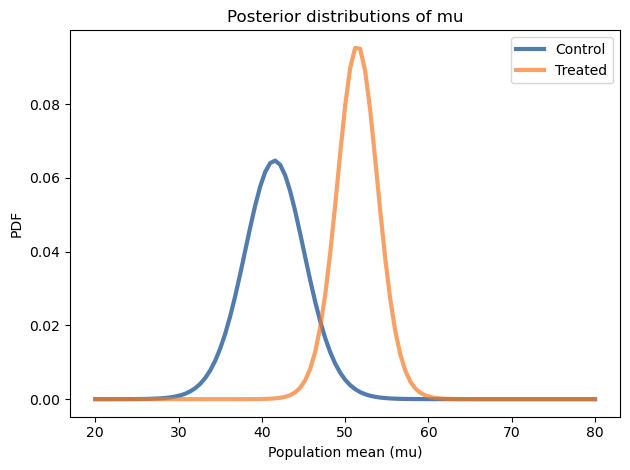

In [58]:
pmf_mean_control.plot(label='Control')
pmf_mean_treated.plot(label='Treated')

decorate(xlabel='Population mean (mu)', ylabel='PDF', title='Posterior distributions of mu')

#### 양쪽 모두 범위 끝쪽의 사후평균은 0에 가까움 $\rightarrow$ 사전 평균에서 정한 범위가 충분했음을 알 수 있음

<br>

#### 두 집단의 주변분포를 비교해보면, 실험군의 모평균이 더 높음
- **실험군 평균이 더 높을 확률은 약 98%**

In [56]:
Pmf.prob_gt(pmf_mean_treated, pmf_mean_control)

0.9804790251873259

<br>

## 13.05. 차이의 분포

#### 집단간 차이 정도를 수량화

<br>

#### `Pmf.sub_dist()` : 차이의 분포 계산
- **`Pmf.sub_dist()`는 결괏값이 원래 Pmf보다 많은 원소를 포함**

    최악의 경우, 결괏값의 크기는 원래 데이터의 크기 간의 외적만큼 증가
   

In [59]:
pmf_diff = Pmf.sub_dist(pmf_mean_treated, pmf_mean_control)

In [60]:
len(pmf_mean_treated), len(pmf_mean_control), len(pmf_diff)

(101, 101, 879)

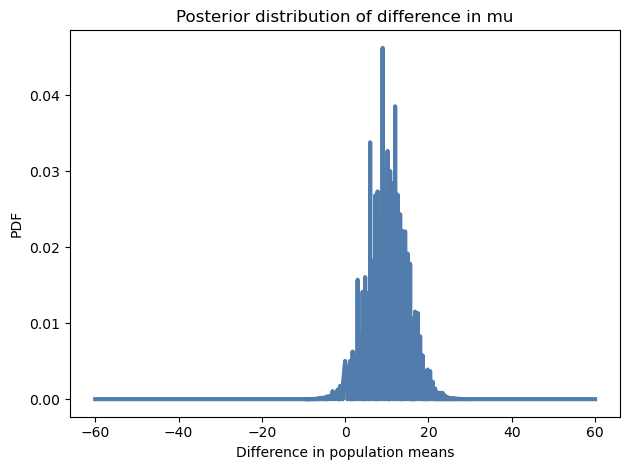

In [61]:
pmf_diff.plot()

decorate(xlabel='Difference in population means', ylabel='PDF', title='Posterior distribution of difference in mu')

#### **이러한 `Pmf.sub_dist()`메소드를 보완하기 위하여, CDF계산 혹은 KDE를 사용해서 PDF의 평활추정**

<br>


#### (1) 차이의 분포에 대한 CDF 

In [64]:
cdf_diff = pmf_diff.make_cdf()

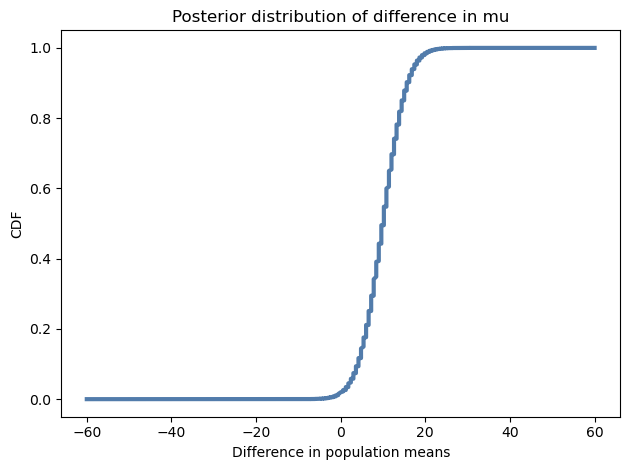

In [65]:
cdf_diff.plot()

decorate(xlabel='Difference in population means', ylabel='CDF', title='Posterior distribution of difference in mu')

<br>

#### (2) 커널 밀도 추정 (kernel density estimation) (KDE)
- 동일하게 나눠진 격자 상에서 PDF의 평활추정을 계산

In [66]:
from scipy.stats import gaussian_kde

In [67]:
def kde_from_pmf(pmf, n=101):
    
    """PMF에 대한 커널 밀도 추정"""
    kde = gaussian_kde(pmf.qs, weights=pmf.ps)
    qs = np.linspace(pmf.qs.min(), pmf.qs.max(), n)
    ps = kde.evaluate(qs)
    pmf = Pmf(ps, qs)
    pmf.normalize()
    
    return pmf

In [68]:
kde_diff = kde_from_pmf(pmf_diff)

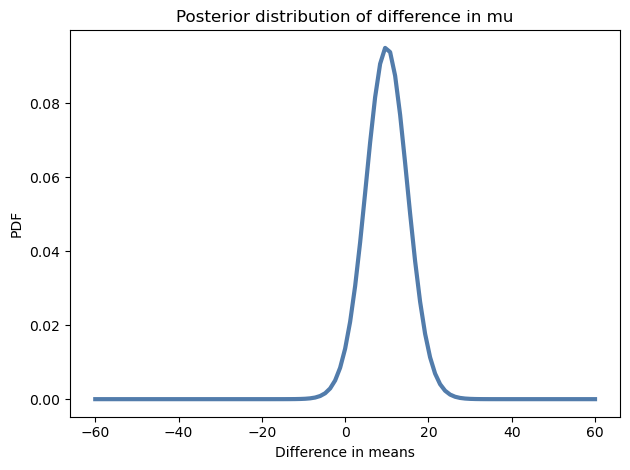

In [69]:
kde_diff.plot()

decorate(xlabel='Difference in means', ylabel='PDF', title='Posterior distribution of difference in mu')

<br>

#### 두 집단간 평균 차이는 약 10점

In [70]:
pmf_diff.mean()

9.954413088940848

- **90% 신용구간**

In [71]:
pmf_diff.credible_interval(0.9)

array([ 2.4, 17.4])

<br>

#### 신용구간에 따르면, 시험 점수를 2점에서 17점 정도 올리는 효과가 있었던 것으로 추정

<br>

<br>

## 13.06. 요약통계 사용

#### 큰 데이터셋을 사용하는 경우, 가능도는 매우 작아져서, 부동 소숫점 연산을 사용해서 구하기 어려움
#### $\rightarrow$ 데이터 셋의 요약값을 구하고, 그 요약값의 가능도를 계산
- 예: 어느 데이터의 평균과 표준편차를 구함 $\rightarrow$ 각 가설 하에서의 요약통계값의 가능도 계산

<br>

#### 어느 집단의 모평균 $\mu$가 42이고, 모표준편차 $\sigma$가 17일 때

In [72]:
mu = 42
sigma = 17

#### 이 모집단에서 임의로 크기 $n=20$인 표분을 추출
* 표본의 평균 : $m=41$, 

    표본의 표준편차 $:\;s=18$

In [73]:
n = 20
m = 41
s = 18

**요약통계량 $m$과 $s$는 $\mu$및 $\sigma$와 그다지 큰 차이가 나지 않음**

#### 수리통계의 다음 3가지 결과를 사용하여, 값의 가능도를 계산

1. $\mu$와 $\sigma$가 주어진 경우, $m$의 분포는 $\mu$와 $\sigma/\sqrt{n}$을 매개변수로 사용하는 정규분포를 따름

$$m \sim N(\mu, \sigma/\sqrt{n})$$

<br>

2. $t=ns^2/\sigma^2$의 분포는, 매개변수 $n-1$를 사용하는 카이제곱분포를 따름
3. 바수의 정리 (Basu's Theorem)에 다르면 ,$m$과 $s$는 서로 독립적

<br>

### $m$의 분포
#### $m$의 분포를 나타내는 정규분포 객체 (평균의 표본 분포)

In [74]:
dist_m = norm(mu, sigma/np.sqrt(n))

- $m=41$일 때, 관측값의 가능도

In [75]:
like1 = dist_m.pdf(m)
like1

0.10137915138497372

<br>

### $t$의 분포


In [76]:
t = n * s**2 / sigma**2
t

22.422145328719722

- 자유도 $n-1$의 카이제곱 분포

In [78]:
from scipy.stats import chi2

In [79]:
dist_s = chi2(n-1)

* $t=22.4221$일 때, 관측값의 가능도

In [80]:
like2 = dist_s.pdf(t)
like2

0.04736427909437004

<br>

#### 표본평균 $m$과 표본표준편차$s$는 서로 독립이므로, 둘의 결합 가능도는 가능도 간의 곱으로 구할 수 있음

In [81]:
like = like1 * like2
like

0.004801750420548287

<br>

## 13.07. 요약통계 갱신

#### 다음 두 군집에 대한 요약통계

In [82]:
summary = {}

for name, response in responses.items():
    summary[name] = len(response), response.mean(), response.std()
    
summary

{'Control': (23, 41.52173913043478, 17.148733229699484),
 'Treated': (21, 51.476190476190474, 11.00735684721381)}

<br>

#### 통제군의 크기, 표본평균, 표본표준편차

In [86]:
n, m, s = summary['Control']

- **$x$축에는 `mu`의 가설값, $y$축에는 `sigma`의 가설 값을 넣은 메쉬 그리드 생성**

In [87]:
mus, sigmas = np.meshgrid(prior.columns, prior.index)
mus.shape

(101, 101)

#### 각 매개변수의 쌍으로부터  표본 평균이 $m$이 될 가능도 계산

In [88]:
like1 = norm(mus, sigmas/np.sqrt(n)).pdf(m)
like1.shape

(101, 101)

#### 각 매개변수의 쌍으로부터 표본 표준편차가 $s$가 될 가능도 계산

In [89]:
ts = n * s**2 / sigmas**2
like2 = chi2(n-1).pdf(ts)
like2.shape

(101, 101)

#### 마지막으로, 두 가능도를 모두 갱신

In [90]:
posterior_control2 = prior * like1 * like2
normalize(posterior_control2)

0.00030965351017402847

*위의 단계를 하나의 함수로 표현*

In [91]:
def update_norm_summary(prior, data):
    """요약통계량을 사용해서 정규분포를 갱신"""
    n, m, s = data
    mu_mesh, sigma_mesh = np.meshgrid(prior.columns, prior.index)
    
    like1 = norm(mu_mesh, sigma_mesh/np.sqrt(n)).pdf(m)
    like2 = chi2(n-1).pdf(n * s**2 / sigma_mesh**2)
    
    posterior = prior * like1 * like2
    normalize(posterior)
    
    return posterior

<br>

#### 실험군에 대한 갱신

In [92]:
data = summary['Treated']
posterior_treated2 = update_norm_summary(prior, data)

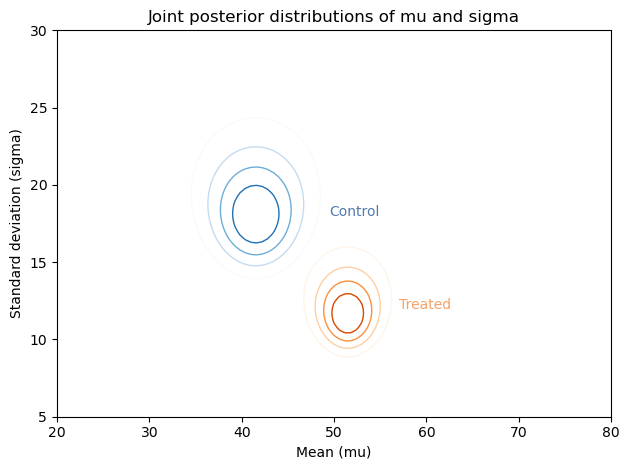

In [93]:
plot_contour(posterior_control2, cmap='Blues')
plt.text(49.5, 18, 'Control', color='C0')

cs = plot_contour(posterior_treated2, cmap='Oranges')
plt.text(57, 12, 'Treated', color='C1')

decorate(xlabel='Mean (mu)', ylabel='Standard deviation (sigma)', title='Joint posterior distributions of mu and sigma')

#### 위 사후결합분포는 전체 데이터를 가지고 계싼한 결과와 비슷하지만, 주변분포를 비교해보면 완전히 동일하지는 않음

<br>

## 주변분포 비교


In [95]:
from utils import marginal

In [94]:
pmf_mean_control2 = marginal(posterior_control2, 0)
pmf_mean_treated2 = marginal(posterior_treated2, 0)

- **전체 데이터에서 구한 결과 (점선)와 비교**

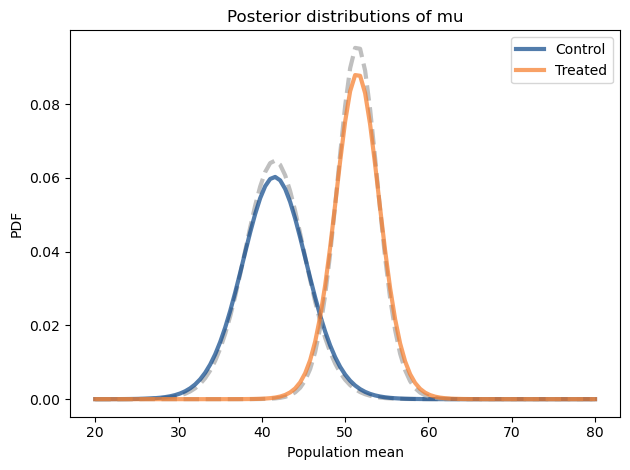

In [96]:
pmf_mean_control.plot(color='C5', ls='--')
pmf_mean_control2.plot(label='Control')
pmf_mean_treated.plot(color='C5', ls='--')
pmf_mean_treated2.plot(label='Treated')

decorate(xlabel='Population mean', ylabel='PDF', title='Posterior distributions of mu')

#### 요약통계량 기반 사후분포는 전체 데이터를 사용해서 구했던 사후분포와 유사하지만, 두 경우 모두 좀 더 짧고 옆으로 넓은 형태를 보임
- **이는 데이터의 분포가 정규분포를 따른다고 가정하고, 요약통계량을 사용하여 갱신을 하기 때문**
    - 이 가정은 불완전하기 때문에, 전체 데이터 대신 요약통계량을 사용하는 경우, 데이터의 실제 분포에 따른 일부 정보를 잃어버릴 수 있음
- **정보가 적어지면, 매개변수에 대한 확실성이 낮아질 수 밖에 없음**

<br>

## 13.09. 시뮬레이션을 통한 증명
### 모집단의 실제 평균과 표준편차를 알고 있다고 가정


In [97]:
mu = 42
sigma = 17

In [98]:
dist = norm(mu, sigma)

#### **`norm` 객체의 분포에서 임의의 값을 생성하는 `rvs`메소드로, 각각의 샘플 크기가 `n=20`인 1000개의 샘플을 시뮬레이션**

In [99]:
n = 20
samples = dist.rvs((1000, n))
samples.shape

(1000, 20)

#### 결과는 1000개의 행으로 구성된 배열이며, 각 행에는 샘플 또는 20개의 시뮬레이션된 테스트 점수가 포함

<br>

#### 각 행의 평균을 계산하면 결과는 1000개의 샘플 평균에 대한 배열. 

**즉, 각 값은 'n=20'인 표본의 평균**

In [101]:
sample_means = samples.mean(axis=1)
sample_means.shape

(1000,)

<br>

#### $m$의 분포를 나타내는 정규분포 객체 (평균의 표본에 대한 이론적 분포)

In [117]:
dist_m = norm(mu, sigma/np.sqrt(n))

<br>

### 표본평균의 분포를 이론적 분포인 `dist_m`과 비교

In [104]:
def pmf_from_dist(dist, low, high):
    """연속 분포에 대한 이산 근사치를 생성
    
    dist: SciPy dist object
    low: low end of range
    high: high end of range
    
    returns: normalized Pmf
    """
    qs = np.linspace(low, high, 101)
    ps = dist.pdf(qs)
    pmf = Pmf(ps, qs)
    pmf.normalize()
    return pmf

In [118]:
low = dist_m.mean() - dist_m.std() * 3
high = dist_m.mean() + dist_m.std() * 3

pmf_m = pmf_from_dist(dist_m, low, high)

<br>

#### 이론적 분포를 표본의 평균과 비교
- **`kde_from_sample`을 사용하여, 1000개의 표본 평균에 대한 분포를 추정하고**

    **이론적 분포인`pmf_m`과 동일한 값에 대하여 평가**

In [119]:
from utils import kde_from_sample

In [120]:
qs = pmf_m.qs
pmf_sample_means = kde_from_sample(sample_means, qs)

#### 이론적 분포와 표본 평균의 분포가 일치함을 확인

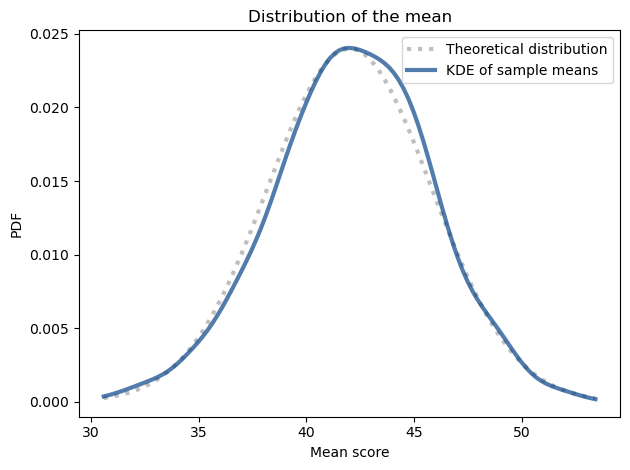

In [121]:
pmf_m.plot(label='Theoretical distribution', ls=':', color='C5')
pmf_sample_means.plot(label='KDE of sample means')

decorate(xlabel='Mean score', ylabel='PDF', title='Distribution of the mean')

<br>

### 표본 표준편차에 대한 확인

#### 1000개 샘플 각각에 대한 표준 편차를 계산

In [122]:
sample_stds = samples.std(axis=1)
sample_stds.shape

(1000,)

In [123]:
transformed = n * sample_stds**2 / sigma**2

<br>

#### $t$의 분포를 나타내는 자유도 $n-1$의 카이제곱분포 객체 (표본표준편차에 대한 이론적 분포)

In [124]:
dist_s = chi2(n-1)

<br>

### 표본표준편차의 분포를 이론적 분포인 `dist_s`과 비교

In [126]:
low = 0
high = dist_s.mean() + dist_s.std() * 4

pmf_s = pmf_from_dist(dist_s, low, high)

In [127]:
qs = pmf_s.qs
pmf_sample_stds = kde_from_sample(transformed, qs)

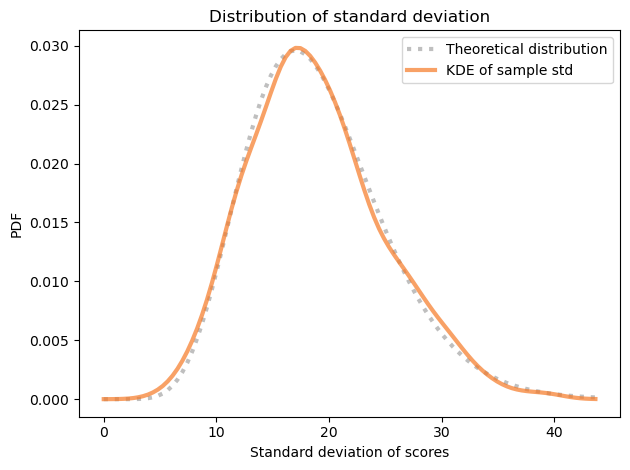

In [129]:
pmf_s.plot(label='Theoretical distribution', ls=':', color='C5')
pmf_sample_stds.plot(label='KDE of sample std', color='C1')

decorate(xlabel='Standard deviation of scores', ylabel='PDF', title='Distribution of standard deviation')

#### 표준 편차의 분포는 이론적 분포와 일치함을 확인.

<br>

### 표본 평균과 표준 편차간 독립성 확인
* 상관관계는 0에 가까움

<br>

#### 따라서 시뮬레이션은 요약 통계를 사용하여 업데이트하는 데 사용한 이론적 가정이 적절함을 확인

In [130]:
np.corrcoef(sample_means, sample_stds)[0][1]

0.008340613285428388

<br>

### 결합분포 확인
* 타원의 축이 축과 정렬되어 있는 것처럼 보이며 이는 변수가 독립적임을 나타냄

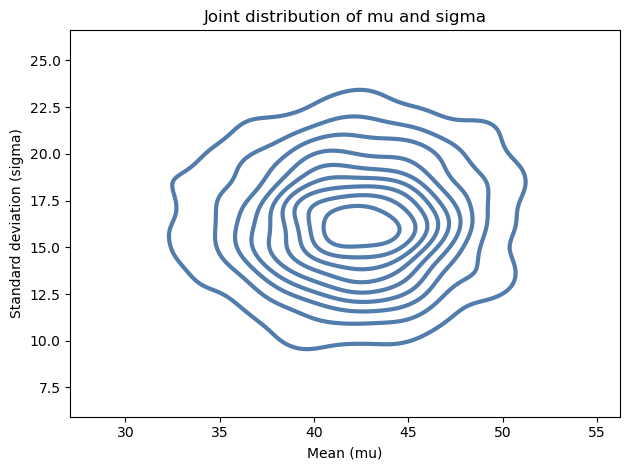

In [132]:
import seaborn as sns

sns.kdeplot(x=sample_means, y=sample_stds)

decorate(xlabel='Mean (mu)', ylabel='Standard deviation (sigma)', title='Joint distribution of mu and sigma')

<br>

## 13.10. 예제

### (1)

### 두 집단의 `sigma`의 사후주변분포를 통하여, 통제군의 표준 편차가 더 높을 확률을 계산

In [140]:
pmf_std_control = marginal(posterior_control, 1)
pmf_std_treated = marginal(posterior_treated, 1)

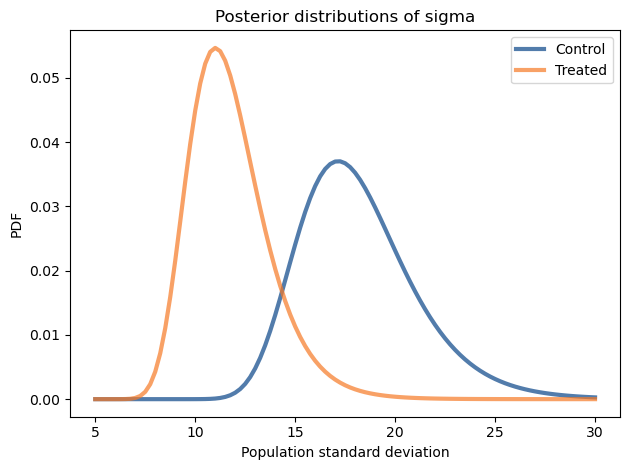

In [141]:
pmf_std_control.plot(label='Control')
pmf_std_treated.plot(label='Treated')

decorate(xlabel='Population standard deviation', ylabel='PDF', title='Posterior distributions of sigma')

**통제군의 표준 편차가 더 높을 확률은 96.85%**

In [142]:
Pmf.prob_gt(pmf_std_control, pmf_std_treated)

0.9685103375300469

<br>

### 두 집단 간의 `sigma`의 차이의 분포를 통하여, 차이의 평균과 90% 신용구간을 계산

In [143]:
pmf_diff2 = Pmf.sub_dist(pmf_std_control, pmf_std_treated)

In [144]:
pmf_diff2.mean()

6.41717132817218

In [146]:
pmf_diff2.credible_interval(0.9)

array([ 1. , 12.5])

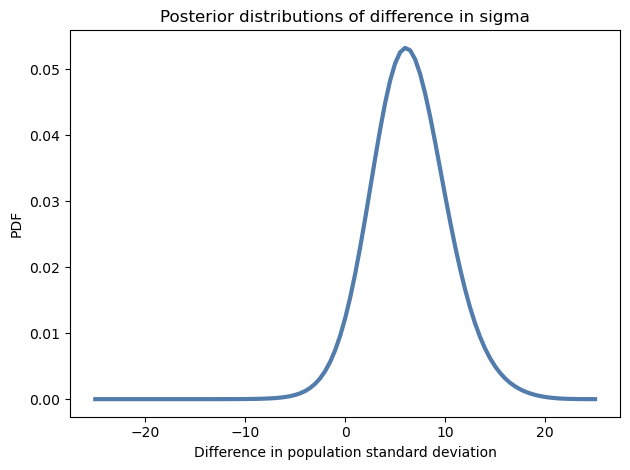

In [147]:
kde_from_pmf(pmf_diff2).plot()

decorate(xlabel='Difference in population standard deviation', ylabel='PDF', title='Posterior distributions of difference in sigma')

<br>

### (2)

[효과크기](http://en.wikipedia.org/wiki/Effect_size) 는 특정 현상의 크기를 계량한 통계량. 이 현상이 두 군집 간의 평균의 차이를 만든다면, 이는 일반적으로 $d$라고 나타내는 코헨의 효과크기로 측정할 수 있다. 

군집1의 매개변수를 $(\mu_1, \sigma_1)$라고 하고, 군집2의 매개변수를 $(\mu_2, \sigma_2)$라고 한다면, 코헨의 효과크기는

$$ d = \frac{\mu_1 - \mu_2}{(\sigma_1 + \sigma_2)/2} $$

두 군집 간의 사후결합분포를 사용해서 코헨의 효과크기의 사후분포를 계산

<br>

**두 분포의 모든 쌍을 열거하지 않고, 무작위 샘플링을 사용**

**다음 함수는 결합 사후 분포를 취하고 쌍의 샘플을 반환**

In [159]:
def sample_joint(joint, size):
    """결합 분포에서 표본 추출"""
    
    pmf = Pmf(joint.transpose().stack())
    return pmf.choice(size)

**두 그룹의 사후 분포에서 쌍을 샘플링하는 데 사용**

In [149]:
sample_treated = sample_joint(posterior_treated, 1000)
sample_treated.shape

(1000,)

In [150]:
sample_control = sample_joint(posterior_control, 1000)
sample_control.shape

(1000,)

#### 샘플링을 반복하고, 각각에 대한 Cohen 효과 크기를 계산, 효과 크기 분포를 추정

In [151]:
def cohen_effect(pair1, pair2):
    """코헨 효과크기 계산"""
    mu1, sigma1 = pair1 
    mu2, sigma2 = pair2
    sigma = (sigma1 + sigma2) / 2
    return (mu1 - mu2) / sigma

In [153]:
cohen_effect(sample_treated[0], sample_control[0])

0.6

In [154]:
ds = []
for pair1, pair2 in zip(sample_treated, sample_control):
    d = cohen_effect(pair1, pair2)
    ds.append(d)

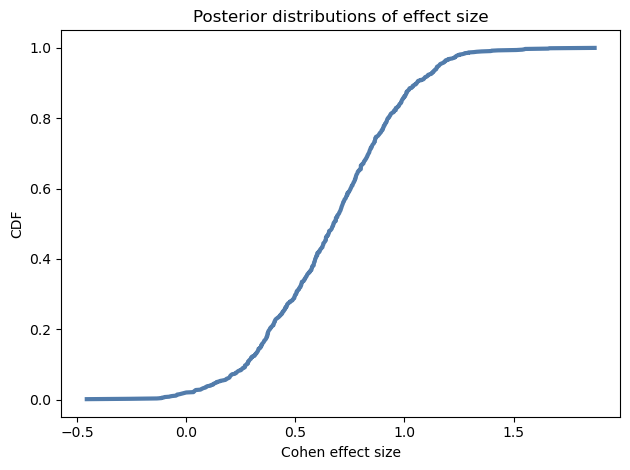

In [155]:
cdf = Cdf.from_seq(ds)
cdf.plot()

decorate(xlabel='Cohen effect size', ylabel='CDF', title='Posterior distributions of effect size')

In [156]:
cdf.mean()

0.6663987127348774

In [157]:
cdf.credible_interval(0.9)

array([0.14117647, 1.15862069])